## Outline

* Recap of data
* Feedforward network with Pytorch tensors and autograd
* Using Pytorch's NN -> Functional, Linear, Sequential & Pytorch's Optim
* Moving things to CUDA

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

import torch

In [2]:
torch.manual_seed(0)

In [3]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

## Generate Dataset

In [4]:
# We have already seen this datasetes in TrainingFFN we can refer those to understand these
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


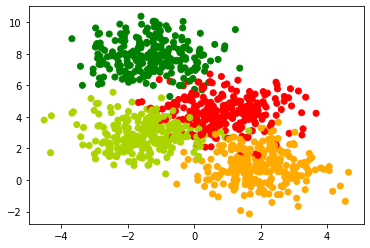

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels.shape)

(750, 2) (250, 2) (1000,)


## Using torch tensors and autograd

We are using the SecondNetowrk.png to make the neural network

In [7]:
# Converting all the train and test data into torch tensors, using the map function
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))

In [8]:
print(X_train.shape, Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


We would like to compute the 4 values y1 y2 y3 y4, which correspond to the interperted praobability of a particular input belonging to the four classes.  

x could be a single data [1,2] item meaing one data item with 2 features or [750,2] which could be the entire batch of the data that we have for training.

We are using a different notation this time - Vector Notation in SecondNetwork.png. We are calling the entire first layer part 1 as a1 and the part 2 as h1. Similarly the second layer first all pre-activations are a2 and activations are h2.

h2 will be equilent to the y outputs because we directly the outputs as the activation outputs to the last layer.


In [9]:
# Forward propagation - modeling the network
# Matrix conventions for dimnetions is we take (input, output)
def model(x):
  a1 = torch.matmul(x, weights1) + bias1 # (N, 2) x (2, 2) -> (N, 2)
  
  # pytorch sigmoid fucntion - will apply sigmoid point wise to all the elements of a1
  h1 = a1.sigmoid() # (N, 2)
  
  a2 = torch.matmul(h1, weights2) + bias2 # (N, 2) x (2, 4) -> (N, 4)
  
  '''  
  Softamx activation function - typical pyTorch notation uses chaining
  a2.exp() is pyTorch notation of exponential function - it will eallpy exponent fx'n to each element of the vector and retain it's size
  The we are dividing it by the sum that we have 
  we are taking a2.exp() and doing submission using sum and -1 in the argument tells us, along which axis we would like to sum. 
  In case of -1 we take the last dimention
  then at the end we unsqueeze - convets a tensor of size of N to change it's dimentions and make it (N,1). 
  The -1 in the argument means in the last add a one'''
  h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1) # (N, 4)
  return h2

In [10]:
# Just for example of the last line of the above code
a = torch.rand(2,4)
print(a)
print()
print(a.exp().sum(0))
print()
print(a.exp().sum(-1), 'The shape is ', a.exp().sum(-1).shape)
print()
print(a.exp().sum(-1).unsqueeze(-1), 'The shape is ', a.exp().sum(-1).unsqueeze(-1).shape)
print()
print(a.exp()/a.exp().sum(-1).unsqueeze(-1), 'The shape is ', (a.exp()/a.exp().sum(-1).unsqueeze(-1)).shape) # this row adds up to 1

tensor([[0.4963, 0.7682, 0.0885, 0.1320],
        [0.3074, 0.6341, 0.4901, 0.8964]])

tensor([3.0025, 4.0412, 2.7250, 3.5920])

tensor([6.0321, 7.3285]) The shape is  torch.Size([2])

tensor([[6.0321],
        [7.3285]]) The shape is  torch.Size([2, 1])

tensor([[0.2723, 0.3574, 0.1811, 0.1892],
        [0.1856, 0.2573, 0.2228, 0.3344]]) The shape is  torch.Size([2, 4])


In [11]:
# Example for loss functions - Cross Entropy & Accuracy
# We are using size of N=2, each of them will have 4 elemnsts adding up to 1
y_hat = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.8, 0.1, 0.05, 0.05]])
# ground truths - we have taken the example such that the ans. of the ground truth is wrong,
# as in the first case 0.4 should be the answer and the index is 3 not 2. In the second case we have the correct answer
y = torch.tensor([2, 0])

# Cross entropy loss
# We need to find from y_hat that elemet which is given by y, -->_hat[range(y_hat.shape[0]), y] read the md below
print((-y_hat[range(y_hat.shape[0]), y].log()).mean().item())

#argmax finds the largest value and gives the index of that, dim =1 means column wise.
# if the max index of y_hat tensor matches with y, then the accuracy max, or else we calculate the mean to find the accuracy
# to apply mean to tensors we need to convert them into float
(torch.argmax(y_hat, dim=1) == y).float().mean().item()

0.7135581970214844


0.5

<pre>
INPUT
print(y_hat[range(y_hat.shape[0])])
print(y_hat[range(y_hat.shape[0]),y])

OUTPUT
tensor([[0.1000, 0.2000, 0.3000, 0.4000],
        [0.8000, 0.1000, 0.0500, 0.0500]])
tensor([0.3000, 0.8000])
</pre>

In [12]:
def loss_fn(y_hat, y):
  return -(y_hat[range(y.shape[0]), y].log()).mean()

In [13]:
def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred == y).float().mean()

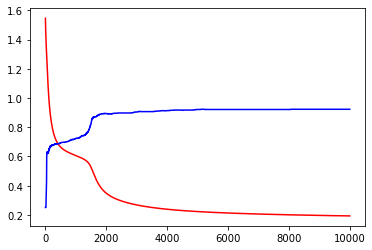

Loss before training 1.5456440448760986
Loss after training 0.19288595020771027


In [14]:
# Bringing everything together. 
torch.manual_seed(0)
# Initiating the weights and bias in the model

# Size taken to be 2,2 as the netowrk that we are modelling has 2 inputs and the firt layer has 2 neurons so 2x2
# Dividing this by number of inputs for Xavier Initialisation. 
weights1 = torch.randn(2, 2) / math.sqrt(2) # dividing this by number of inputs for Xavier Initialisation. 
weights1.requires_grad_() # We require grad as we would like to do bookeeping on this as we woucd like to lear these and update based on the loss 
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

# Settingt the learning rate and epochs 
learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
# converted into long as Y_train is being used as an index in the tensor for the loss function
Y_train = Y_train.long()

# Book-keeping for the loss and accuracy
loss_arr = []
acc_arr = []

for epoch in range(epochs):
  # calling the model with the entire batch which is X_train
  y_hat = model(X_train)
  loss = loss_fn(y_hat, Y_train)
  loss.backward()
  # book-keeping and putting the values of loss and accuracy into the list that we created
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat, Y_train))

  # Calculating the gradients and mlutiplying each of them with the learning rate - to update the weights and biases
  # We have wrapped that into torch.no_grad() to avoid further expantion of the computationl graph is happening
  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    # Settingt he parameters to zero again
    weights1.grad.zero_()
    bias1.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()

plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])

We can see that the loss is decreasing(red) and the accuracy is increasing(blue)

## Using NN.Functional

In [15]:
import torch.nn.functional as F

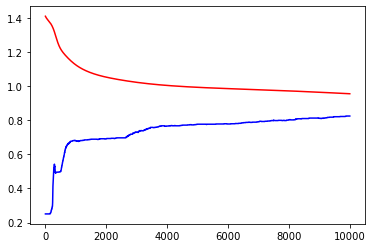

Loss before training 1.4111982583999634
Loss after training 0.9561846256256104


In [16]:
# Everything remains the same except for the fact that we are using Cross Entropy Loss Fuction
torch.manual_seed(0)
weights1 = torch.randn(2, 2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

loss_arr = []
acc_arr = []

for epoch in range(epochs):
  y_hat = model(X_train)
  # Using Cross Entropy Loss
  loss = F.cross_entropy(y_hat, Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat, Y_train))

  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    weights1.grad.zero_()
    bias1.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()

plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])

## Using NN.Parameter

In [17]:
import torch.nn as nn

In [18]:
# We are going to write a class for our netowrk using the Pytorch features

# We are sunclassing nn.Module - The way it is done is when we call an init fucntion we typically call the init of the super (in line 7)
class FirstNetwork(nn.Module):
  
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        # Weights and Biases called as before just wrapping them in nn parameter
        # we do not have to mention .requires_grad as it is taken care by nn.parameter
        self.weights1 = nn.Parameter(torch.randn(2, 2) / math.sqrt(2))
        self.bias1 = nn.Parameter(torch.zeros(2))
        self.weights2 = nn.Parameter(torch.randn(2, 4) / math.sqrt(2))
        self.bias2 = nn.Parameter(torch.zeros(4))
        
    # Forward Propagation
    def forward(self, X):
        a1 = torch.matmul(X, self.weights1) + self.bias1
        h1 = a1.sigmoid()
        a2 = torch.matmul(h1, self.weights2) + self.bias2
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

In [19]:
# Fit function to
def fit(epochs = 1000, learning_rate = 1):
  loss_arr = []
  acc_arr = []
  for epoch in range(epochs):
    y_hat = fn(X_train) # This will be executed from the FirsNetowrk Class - fn is the instantiation of the first netowrk
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    loss.backward()
    with torch.no_grad():
      # Insted of updating turning the weights and bias individually to zero we can now manually do it
      for param in fn.parameters():
        # Making an update as per the update rule
        param -= learning_rate * param.grad
      fn.zero_grad()
        
  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])
  
  # S Basically nn.parametes provides a short hand both at the computation of the gradient and also the 
  # Resetting of the gradient to 0, hence the update rule becomes very simple.
  # Here we see that the fit finction is independent of the model/network


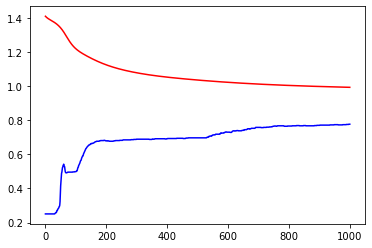

Loss before training 1.4111982583999634
Loss after training 0.9939236044883728


In [20]:
fn = FirstNetwork()
fit()

## Using NN.Linear and Optim

W forstly had paramaetrs and then we were manually writing.  
matrix multiplication and then adding it to them by bias this is a very common thing that happens so we can use nn.Linear to abstract this out

In [21]:
class FirstNetwork_v1(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    # This will automatically have weights and biases
    self.lin1 = nn.Linear(2, 2)
    self.lin2 = nn.Linear(2, 4)
    
  def forward(self, X):
    a1 = self.lin1(X)
    h1 = a1.sigmoid()
    a2 = self.lin2(h1)
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

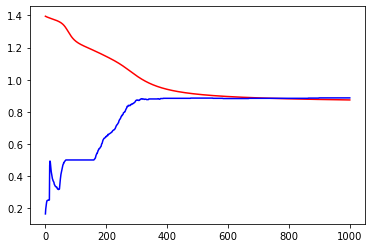

Loss before training 1.3951597213745117
Loss after training 0.8738412857055664


In [22]:
fn = FirstNetwork_v1()
# The fit function remains just the same
fit()

In [23]:
from torch import optim

We have been using stocastic GD in the fit function ourselves, now we are going to use the optim function to run that for us

In [24]:
def fit_v1(epochs = 1000, learning_rate = 1):
  loss_arr = []
  acc_arr = []
  # We are using optim for stocastic gradien decent | We can use optim to do other kinds of GD's too
  opt = optim.SGD(fn.parameters(), lr=learning_rate)
  
  for epoch in range(epochs):
    y_hat = fn(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    loss.backward()
    # Insted of wrapping the weights and biases in nograd and the setitng them to be 0 we are using the following 2 lines of code using optim
    opt.step()
    opt.zero_grad()
        
  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])

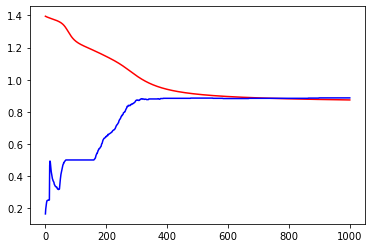

Loss before training 1.3951597213745117
Loss after training 0.8738412857055664


In [25]:
fn = FirstNetwork_v1()
fit_v1()

We are usnig the NN & optim libraries of pytorch to do various things:
1. torch.nn.functional to declare the loss funciton

2. import torch.nn as nn to help us with the forward pass and the backpropagation. It also has a .Linear function which further helps us abstract the forward pass

3. from torch import optim which helps us with the fit funciton in the gradient decent. 

## Using NN.Sequential

We were earlier declareing the Linear layers and then invoking them on forward which seems to a bit redundant.  
We were also using softmax as the activation function and in the output layer we were using softmax function.  
NN.sequetial helps in doing this in a much more cleaner way 

In [26]:
class FirstNetwork_v2(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    # We first define a net followed by series of transforations in order so that our data goes through
    self.net = nn.Sequential(
        nn.Linear(2, 2), 
        nn.Sigmoid(), 
        nn.Linear(2, 4), 
        nn.Softmax()
    )
  # After defing the net the forward functions looks very simple
  def forward(self, X):
    return self.net(X)

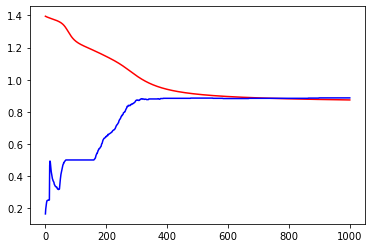

Loss before training 1.3951597213745117
Loss after training 0.873841404914856


In [27]:
# The forward pass looks very neat we should now work on fit function
fn = FirstNetwork_v2()
fit_v1()

In [28]:
# We have removed the book keeping part. We are also showing al the inputs we may want to take as a fit function
def fit_v2(x, y, model, opt, loss_fn, epochs = 1000):
  
  # going through the epochs and calls the loss fx'n on the model of x(given vaule) and y(predicted value)
  for epoch in range(epochs):
    loss = loss_fn(model(x), y)
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
  return loss.item()

In [29]:
# Inovking all the funcitons and classes
fn = FirstNetwork_v2()
loss_fn = F.cross_entropy
opt = optim.SGD(fn.parameters(), lr=1)
fit_v2(X_train, Y_train, fn, opt, loss_fn)
# The final loss matches the one's we were getting earlier

0.873841404914856

## Running it on GPUs

In [34]:
# If we for some reason want to run it on GPU we can type 'cpu' in place of cuda
device = torch.device("cuda")
# we are feeding x_trian and Y_train into 
X_train=X_train.to(device)
Y_train=Y_train.to(device)
fn = FirstNetwork_v2()
fn.to(device)
tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 1.3951594829559326
Time taken 0.797957181930542


### Running Bigger Models

In [35]:
class FirstNetwork_v3(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        # Here we specify the bigger model
        nn.Linear(2, 1024*4), 
        nn.Sigmoid(), 
        nn.Linear(1024*4, 4), 
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)
# Thing to note is that we are running Neural Netowek in the powers of 2 that is because any GPU architecture is 
# so organised that the performence improves much more if we have all work distributions in terms of poers's of 2. 

In [37]:
device = torch.device("cuda")

X_train=X_train.to(device)
Y_train=Y_train.to(device)
fn = FirstNetwork_v3()
fn.to(device)
tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 1.3890228271484375
Time taken 4.3856120109558105
